In [33]:
import os
os.environ["OMP_NUM_THREADS"] = "32"
from graph_tool.all import *
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.covariance import LedoitWolf, OAS
import matplotlib.pyplot as plt
import matplotlib.cm as mpl
import seaborn as sns
import statsmodels.api as sm
from multipy.fdr import qvalue
from multipy.fdr import lsu
import random as rn

import dill

from rpy2.robjects.packages import importr, data

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [34]:
def filterByFDR(g, level, keepOnlyMain):
    # Filtering edges
    pvals = np.array(g.edge_properties["pvalue"].a)

    fdr_ep = g.new_ep("bool", True)
    fdr_ep.a = lsu(pvals, q=level)

    tv = GraphView(g, efilt=fdr_ep)

    # Keeping largest component
    if keepOnlyMain:
        comp, hist = label_components(tv)
        main_component = tv.new_vp("bool", (comp.a == np.where(hist == max(hist))[0][0]))
        tv.vertex_properties["main_component"] = main_component
        tv.set_vertex_filter(main_component)
    return tv

# Introduction

We ouline a series of simulations to illustrate what aspects of the community structure in correlation matrices are captured by different clustering methods.

We will folow the strategy of creading networks with known community structure, adding known weights to the edges, and creating correlations matrices from these known networks. 
We then attempt to recover the original community structure from this correlation matrix.

## Random networks
 
We start with a random network with 50 vertices, generated by a Erdős–Rényi model.

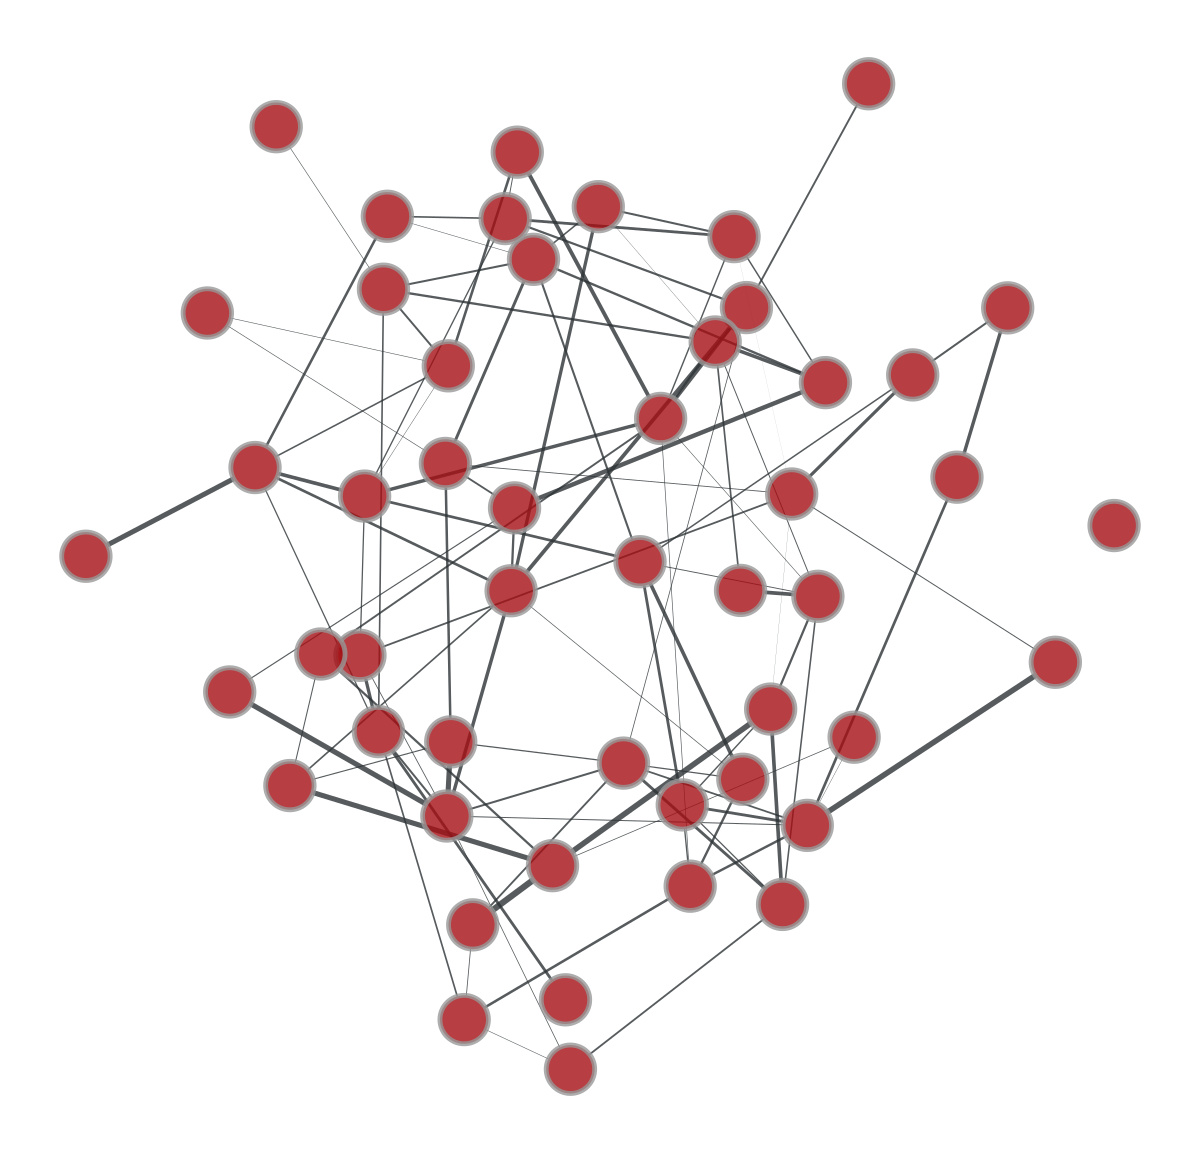

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1d0f54b00, at 0x1d0bf27b0>

In [35]:
np.random.seed(1)
seed_rng(1)
g, pos = triangulation(np.random.random((50,2)))
N = len(g.get_edges())
g.ep.weight = g.new_edge_property("double", np.random.normal(0.6, 1, N))
g.ep.correlations = g.new_edge_property("double", np.tanh(g.ep.weight.a/2))
ret = random_rewire(g, "erdos")
pos = arf_layout(g)
graph_draw(g, pos=pos, edge_pen_width = g.ep.weight)

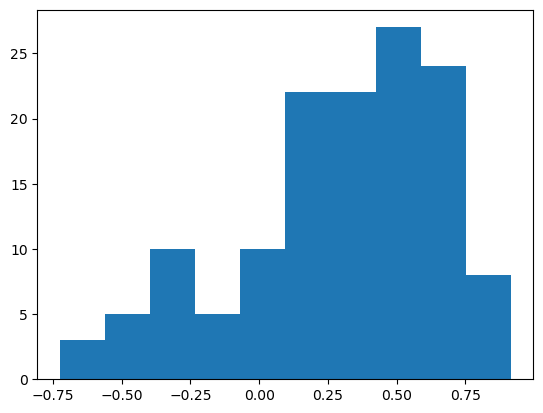

In [36]:
plt.hist(g.ep.correlations.a)
plt.show() 

/var/folders/ph/fmqmjzln2h15bm5bstsgpng80000gn/T/ipykernel_57317/796553485.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  simulated_obs = np.random.multivariate_normal(np.zeros(50), dA, 1000)


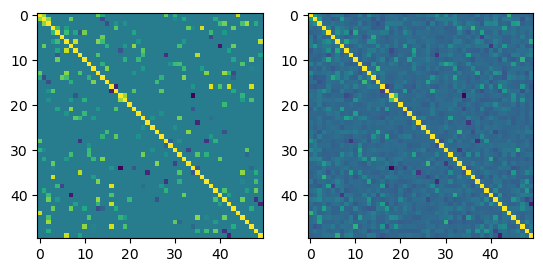

In [37]:
A = adjacency(g, weight=g.ep.correlations)
dA = A.todense()
for i in range(50):
    dA[i,i] = 1
simulated_obs = np.random.multivariate_normal(np.zeros(50), dA, 1000)
import scipy.stats as stats

correlation_matrix = stats.spearmanr(simulated_obs, axis=0).correlation

plt.subplot(1, 2, 1)
plt.imshow(dA, interpolation='nearest')
plt.subplot(1, 2, 2)
plt.imshow(correlation_matrix, interpolation='nearest')
plt.show()

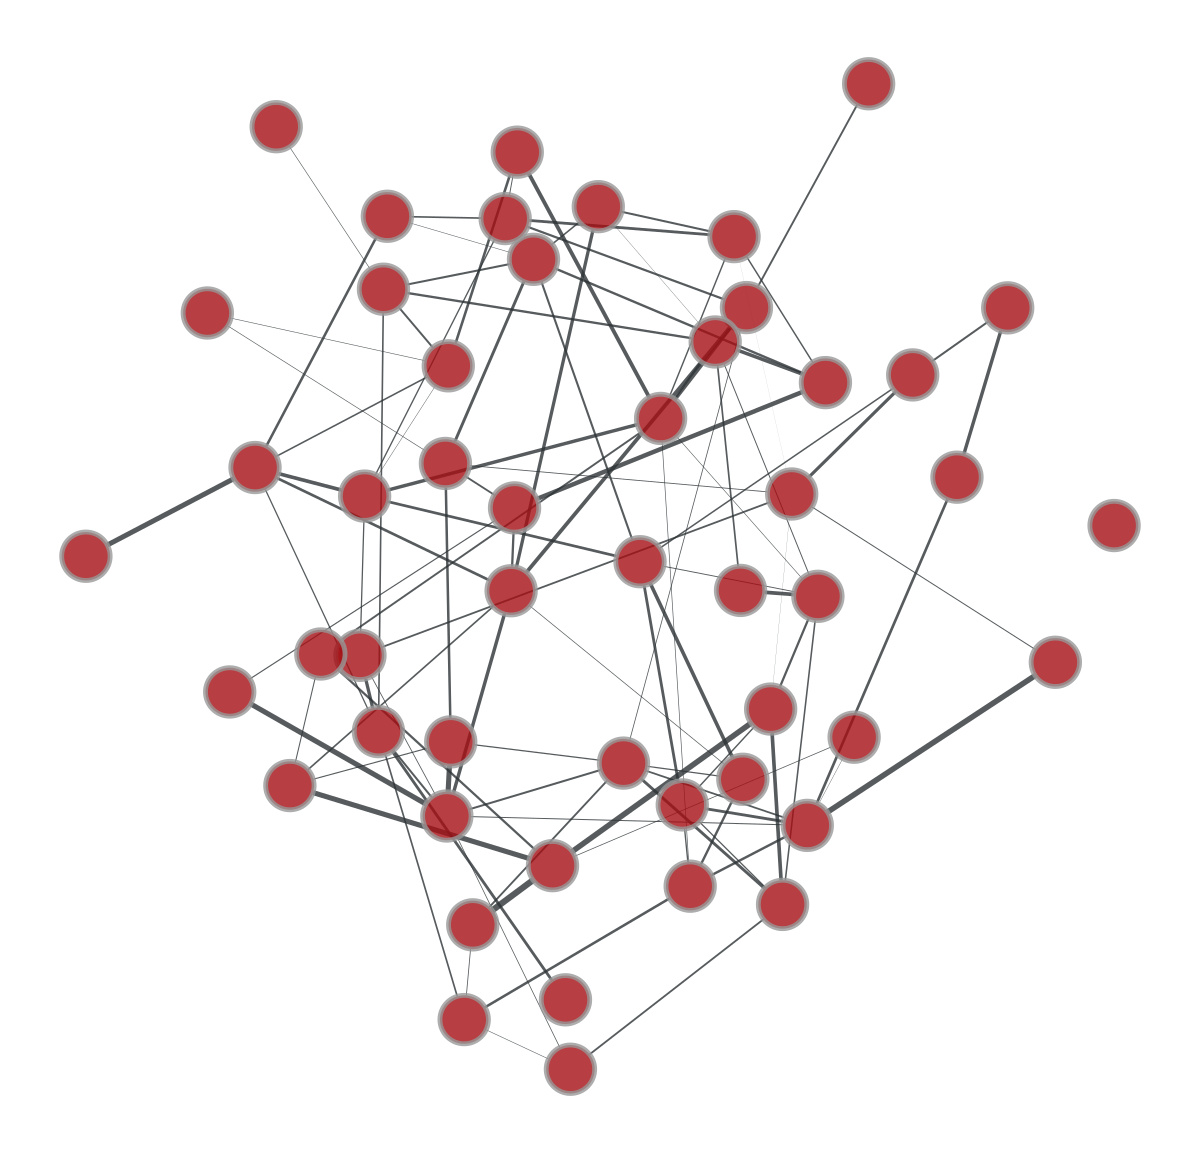

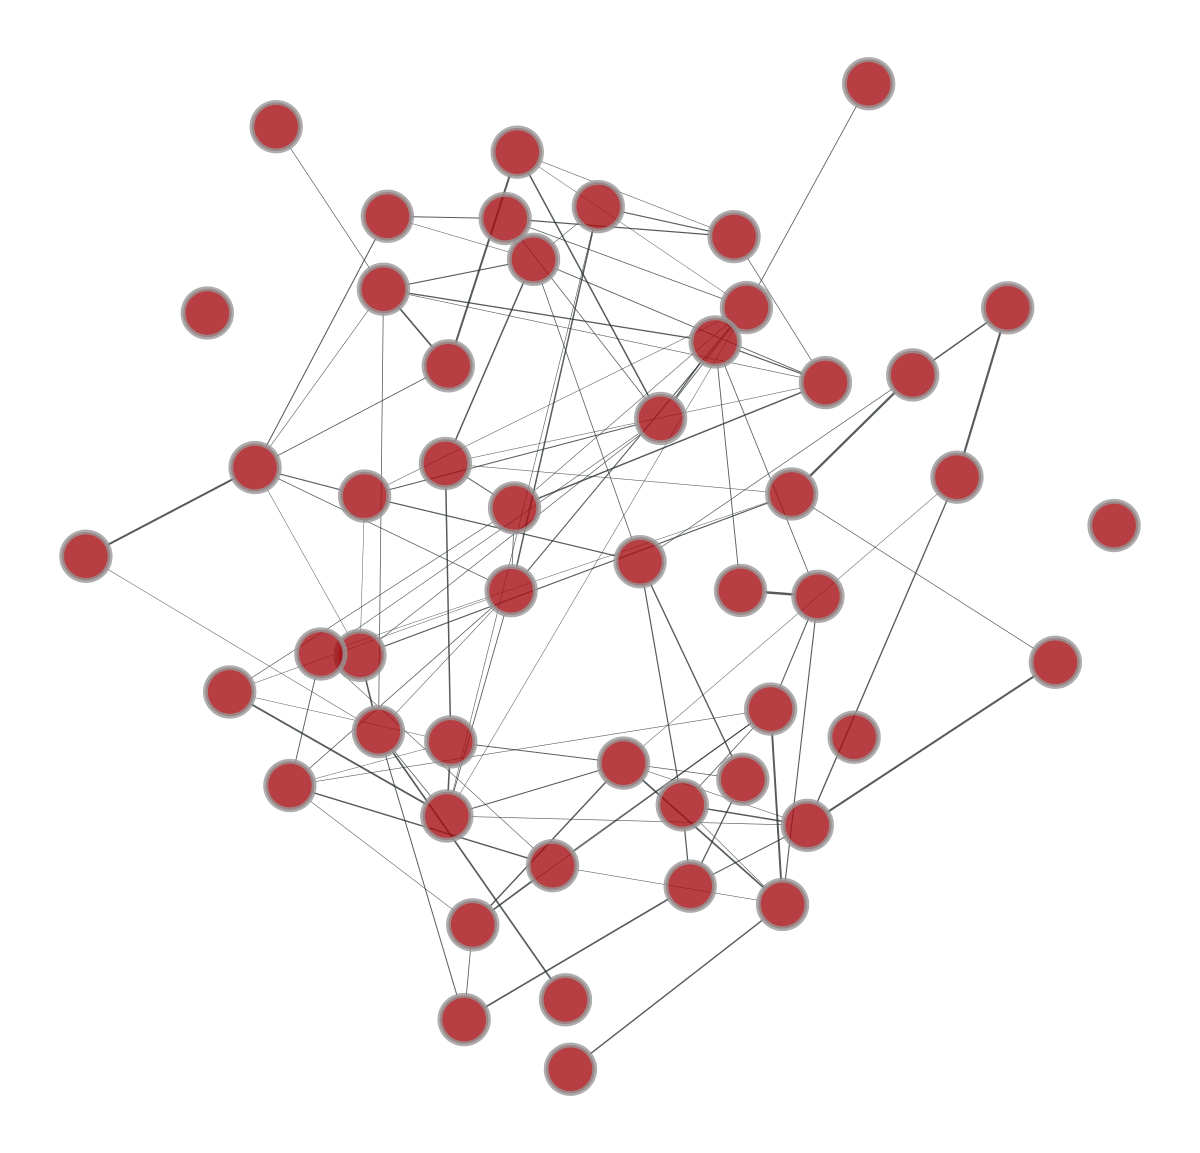

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1d0b5c1a0, at 0x1d0d67860>

In [38]:
gene_expr = simulated_obs

g_obs = Graph(directed=False)
g_obs.add_vertex(n = 50)

spearman = g_obs.new_ep("double", 0)
pval = g_obs.new_ep("double", 0)

for i in range(50):
    for j in range(i):
        spearman_r = sp.stats.spearmanr(gene_expr[:,i], gene_expr[:,j])
        g_obs.add_edge(i, j)
        e = g_obs.edge(i, j)
        pval[e] = spearman_r[1]
        spearman[e] = spearman_r[0]

g_obs.edge_properties["pvalue"] = pval
g_obs.edge_properties["spearman"] = spearman
g_obs.ep.weight = g_obs.new_edge_property("double", 2*np.arctanh(spearman.a))


tv = filterByFDR(g_obs, 1e-3, False)
g_trim = Graph(tv, prune = False)

graph_draw(g, pos=pos, edge_pen_width = g.ep.weight)
graph_draw(g_trim, pos=pos, edge_pen_width = g_trim.ep.weight)

In [39]:
state = minimize_nested_blockmodel_dl(g_trim, state_args=dict(recs=[g_trim.ep.weight],
                                                              rec_types=["real-normal"], deg_corr=True))
mcmc_equilibrate(state, wait=10, nbreaks=2, mcmc_args=dict(niter=10))

(516.5788782935583, 583925, 3612)

In [40]:
# collect nested partitions
bs = []

def collect_partitions(s):
   global bs
   bs.append(s.get_bs())

# Now we collect the marginals for exactly 100,000 sweeps
mcmc_equilibrate(state, force_niter=1000, mcmc_args=dict(niter=10),
                    callback=collect_partitions)

# Disambiguate partitions and obtain marginals
pmode = PartitionModeState(bs, nested=True, converge=True)
pv = pmode.get_marginal(g_trim)

# Get consensus estimate
bs = pmode.get_max_nested()

state = state.copy(bs=bs)


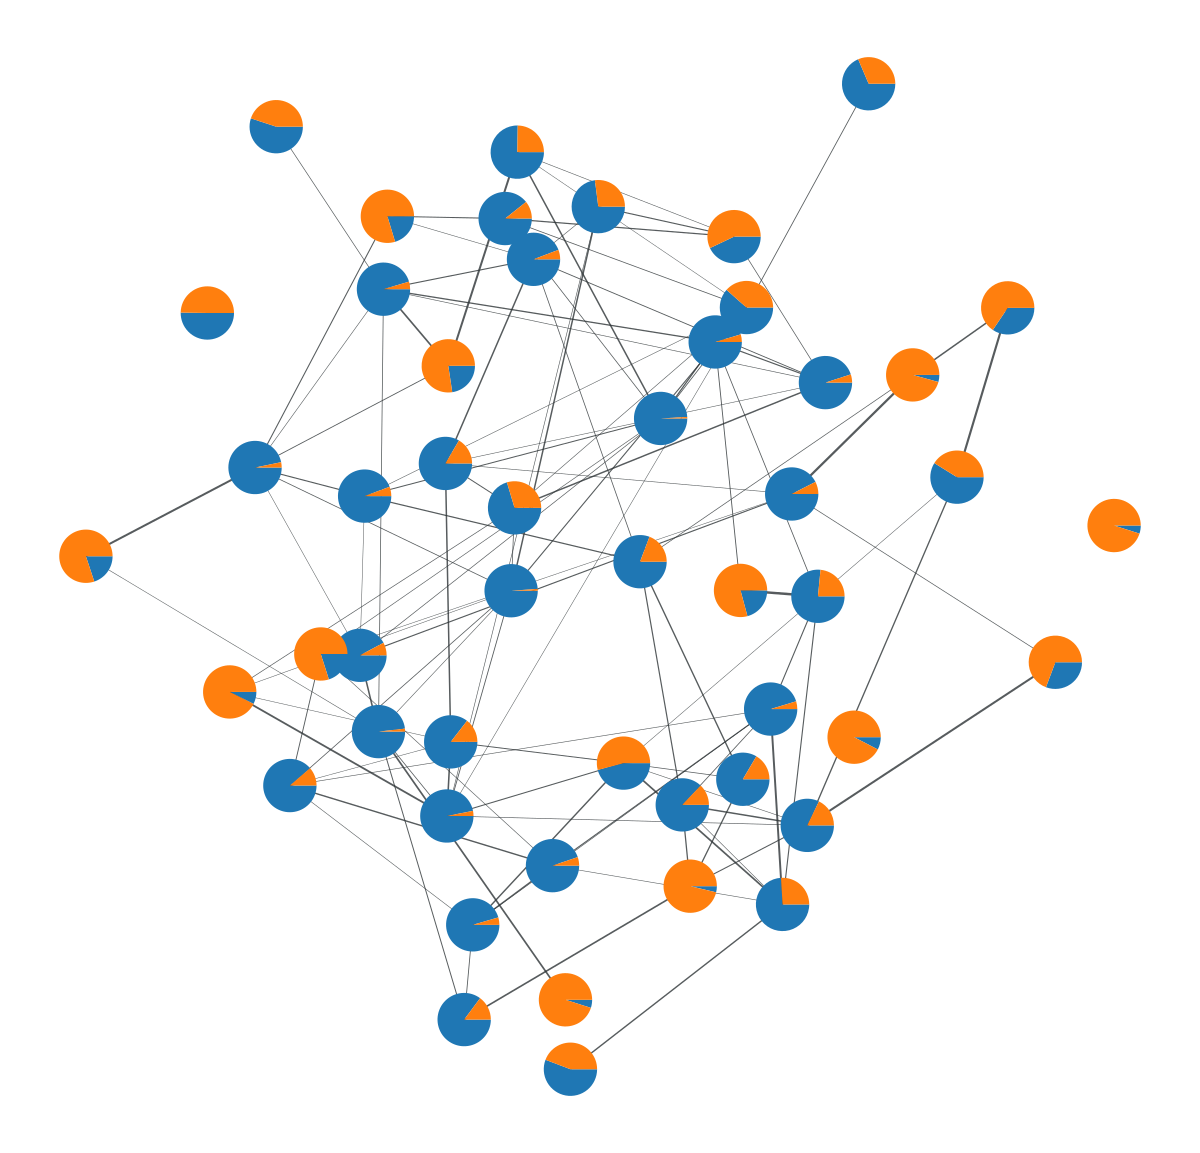

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1d0b5c1a0, at 0x1d100e1e0>

In [41]:

# We can visualize the marginals as pie charts on the nodes:
graph_draw(g_trim, pos=pos, edge_pen_width = g_trim.ep.weight, vertex_shape="pie", vertex_pie_fractions=pv)

# Modular network

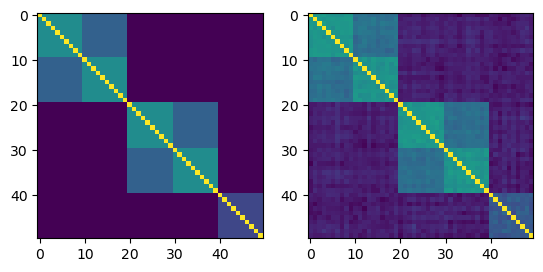

In [63]:
modular_matrix = pd.read_csv("modular_matrix.csv", index_col=0)

np.random.seed(2)
seed_rng(1)
simulated_obs = np.random.multivariate_normal(np.zeros(50), modular_matrix, 1000)
import scipy.stats as stats

correlation_matrix = stats.spearmanr(simulated_obs, axis=0).correlation


plt.subplot(1, 2, 1)
plt.imshow(modular_matrix, interpolation='nearest')
plt.subplot(1, 2, 2)
plt.imshow(correlation_matrix, interpolation='nearest')
plt.show()

In [64]:
np.random.seed(1)
seed_rng(1)

gene_expr = simulated_obs

g_mod = Graph(directed=False)
g_mod.add_vertex(n = 50)

spearman = g_mod.new_ep("double", 0)
pval = g_mod.new_ep("double", 0)

for i in range(50):
    for j in range(i):
        spearman_r = sp.stats.spearmanr(gene_expr[:,i], gene_expr[:,j])
        g_mod.add_edge(i, j)
        e = g_mod.edge(i, j)
        pval[e] = spearman_r[1]
        spearman[e] = spearman_r[0]

g_mod.edge_properties["pvalue"] = pval
g_mod.edge_properties["spearman"] = spearman
g_mod.ep.weight = g_mod.new_edge_property("double", 2*np.arctanh(spearman.a))
community = [1] * 10 + [2] * 10 + [3] * 10 + [4] * 10 + [5] * 10
g_mod.vp.community = g_mod.new_vertex_property("int", community)
upper = [6] * 20 + [7] * 20 + [8] * 10
g_mod.vp.upper = g_mod.new_vertex_property("int", upper)

tv = filterByFDR(g_mod, 1e-3, False)
g_mod_trim = Graph(tv, prune = False)
pos = arf_layout(g_mod_trim)


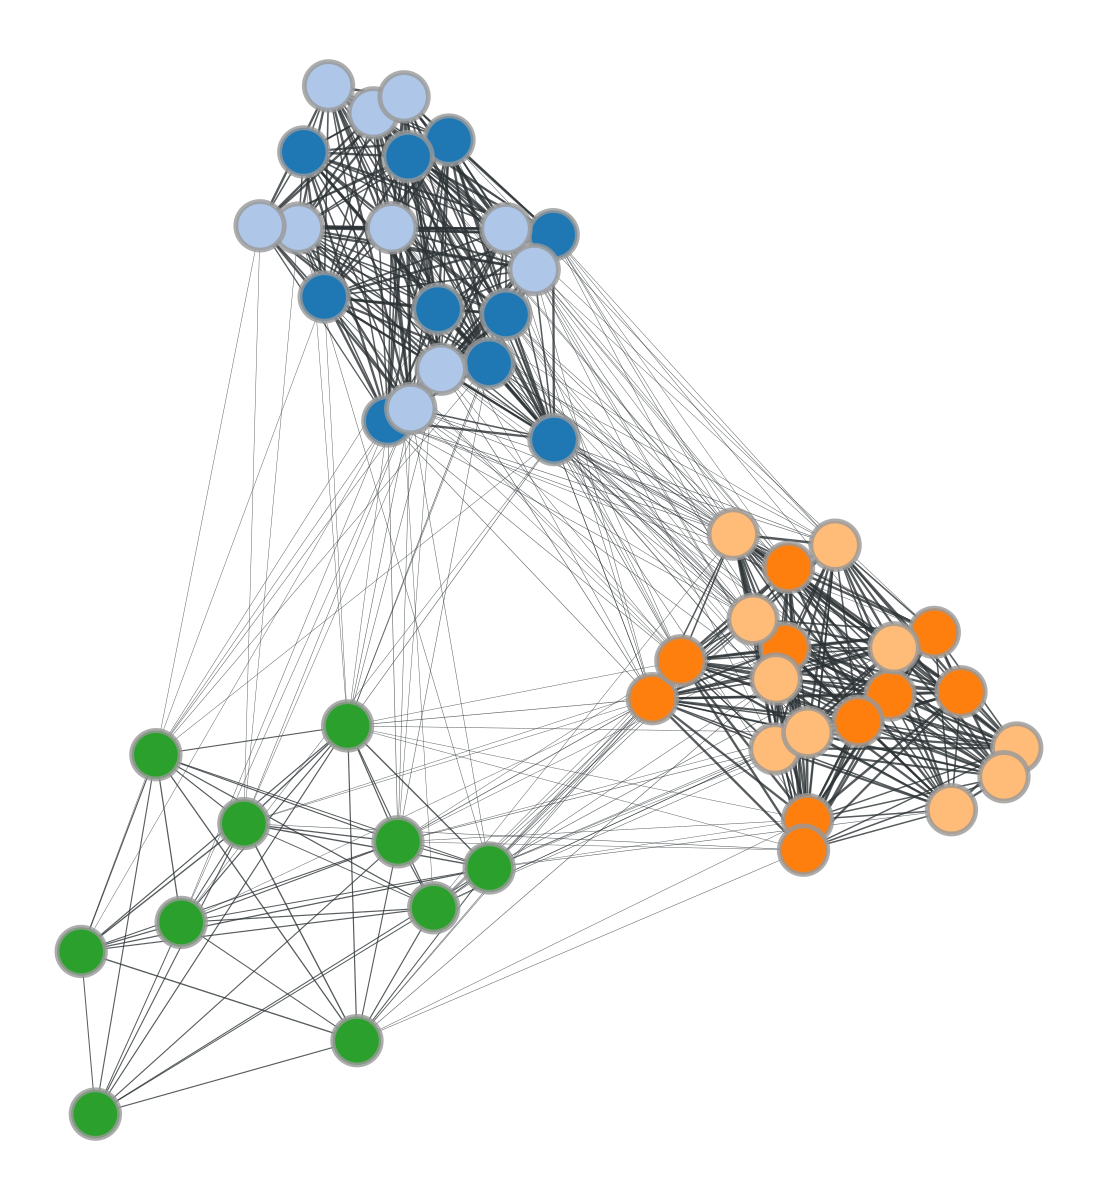

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1d0b70950, at 0x1d0b90fe0>

In [65]:

graph_draw(g_mod_trim, pos = pos, edge_pen_width = g_mod_trim.ep.weight , vertex_fill_color=g_mod_trim.vp.community)

In [45]:
state_mod = minimize_nested_blockmodel_dl(g_mod_trim, state_args=dict(recs=[g_mod_trim.ep.weight],
                                                                  rec_types=["real-normal"]))
mcmc_equilibrate(state_mod, wait=100, nbreaks=2, mcmc_args=dict(niter=10))

(99.54268567301224, 1084601, 286597)

In [46]:
# collect nested partitions
bs = []

def collect_partitions(s):
   global bs
   bs.append(s.get_bs())

# Now we collect the marginals for exactly 100,000 sweeps
mcmc_equilibrate(state_mod, force_niter=1000, mcmc_args=dict(niter=10),
                    callback=collect_partitions)

(99.08467608300246, 3150102, 818507)

In [47]:
# Disambiguate partitions and obtain marginals
pmode = PartitionModeState(bs, nested=True, converge=True)
pv = pmode.get_marginal(g_mod_trim)

# Get consensus estimate
bst = pmode.get_max_nested()
state_mod = state_mod.copy(bs=bst[0:3])

In [48]:

state_mod = state_mod.copy(bs=bst[0:3])
bst

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4], dtype=int32),
 array([1, 1, 0, 0, 0], dtype=int32),
 array([0, 1, 0, 0, 0, 0], dtype=int32),
 array([0, 1], dtype=int32),
 array([0, 1], dtype=int32),
 array([0, 1], dtype=int32),
 array([0, 1], dtype=int32)]

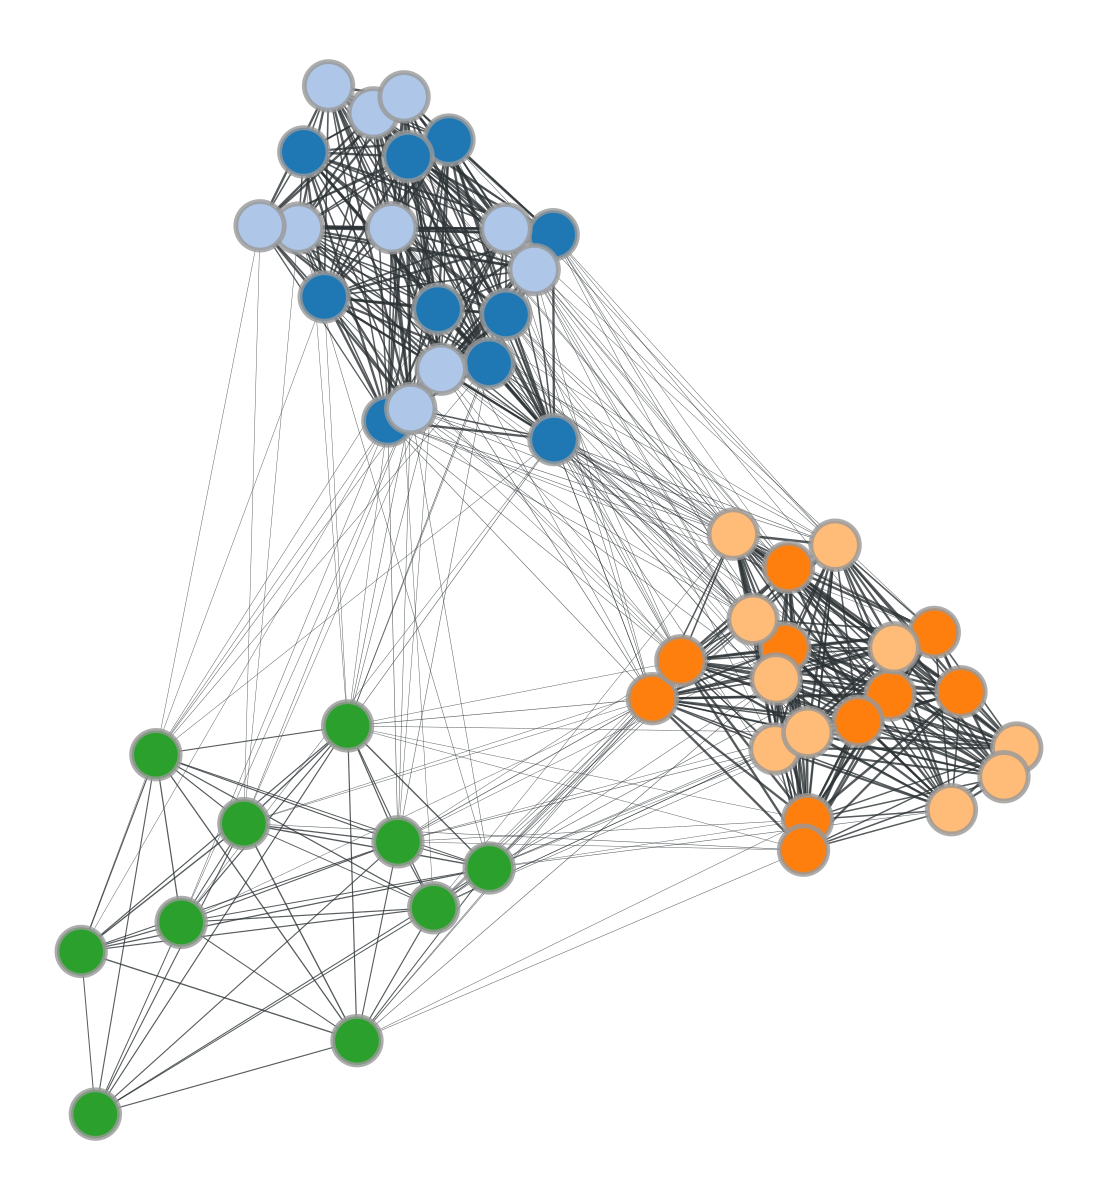

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1d0b70950, at 0x1d0ffddc0>

In [66]:
g_mod_trim.vp.level0 = g_mod_trim.new_vertex_property("int", np.array(state_mod.get_bs()[0]))
graph_draw(g_mod_trim, pos = pos, edge_pen_width = g_mod_trim.ep.weight, 
                                  vertex_fill_color = g_mod_trim.vp.level0)

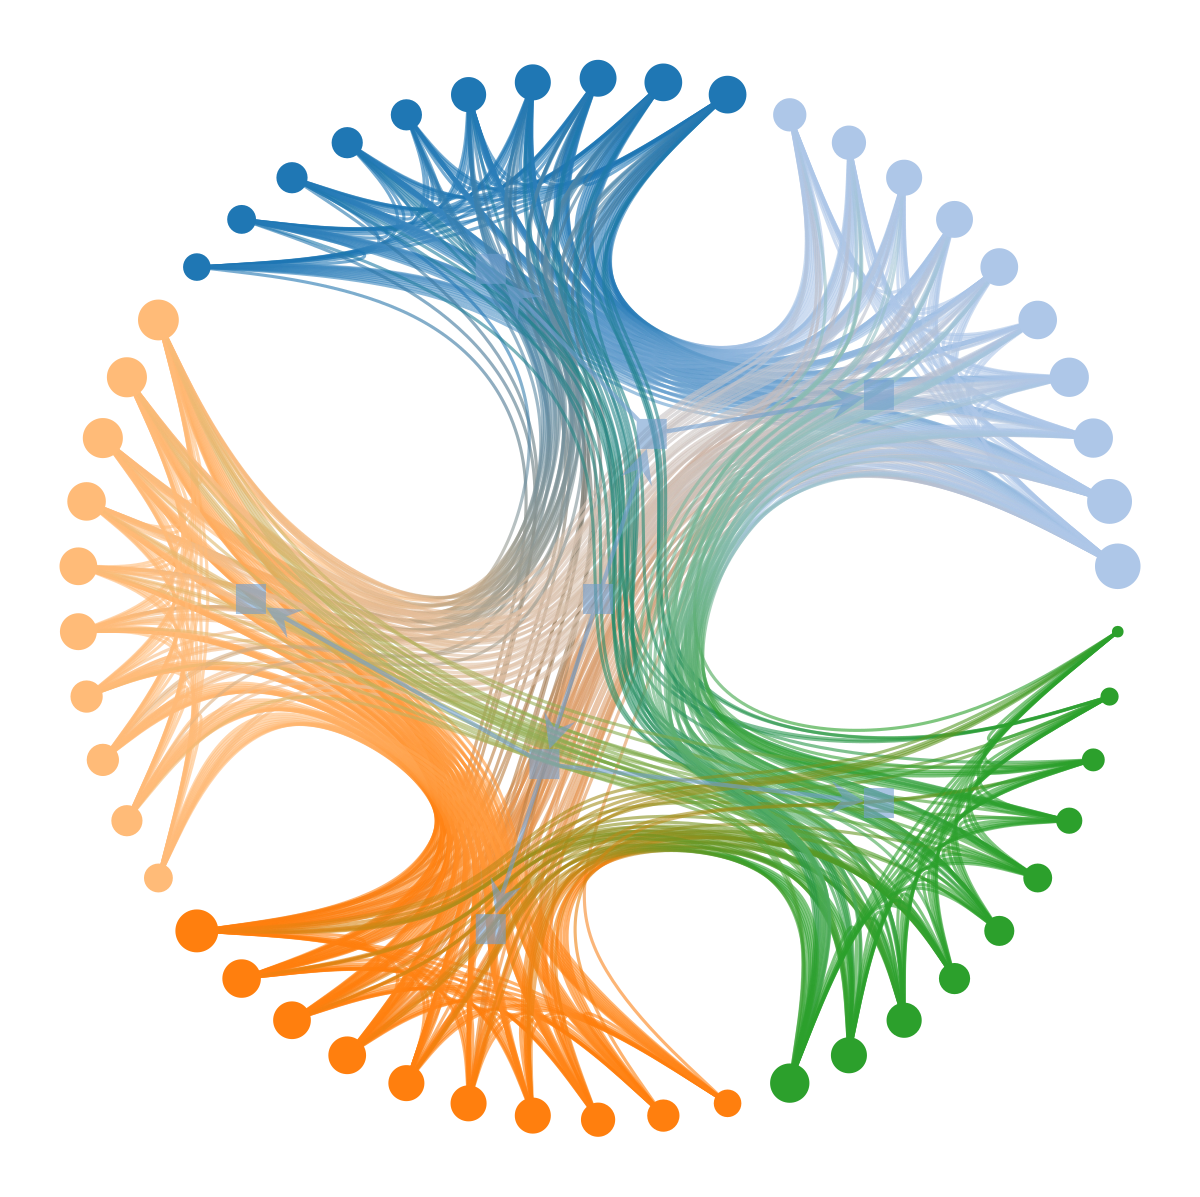

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1d0ffd220, at 0x1d1474590>,
 <GraphView object, directed, with 58 vertices and 57 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x1d100f650, at 0x1d100f350>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x1d100f650, at 0x1d100d880>, False), at 0x1d100f650>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x1d100f650, at 0x1d100ec30>)

In [50]:
state_mod.draw()

# Modular network with one non-assortative group

/var/folders/ph/fmqmjzln2h15bm5bstsgpng80000gn/T/ipykernel_57317/1748894644.py:3: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  simulated_obs = np.random.multivariate_normal(np.zeros(50), non_modular_matrix, 1000)


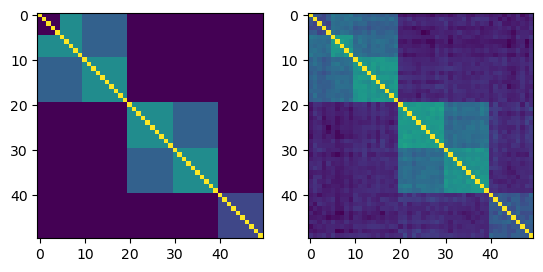

In [51]:
non_modular_matrix = pd.read_csv("non_modular_matrix.csv", index_col=0)

simulated_obs = np.random.multivariate_normal(np.zeros(50), non_modular_matrix, 1000)
import scipy.stats as stats

correlation_matrix = stats.spearmanr(simulated_obs, axis=0).correlation

plt.subplot(1, 2, 1)
plt.imshow(non_modular_matrix, interpolation='nearest')
plt.subplot(1, 2, 2)
plt.imshow(correlation_matrix, interpolation='nearest')
plt.show()

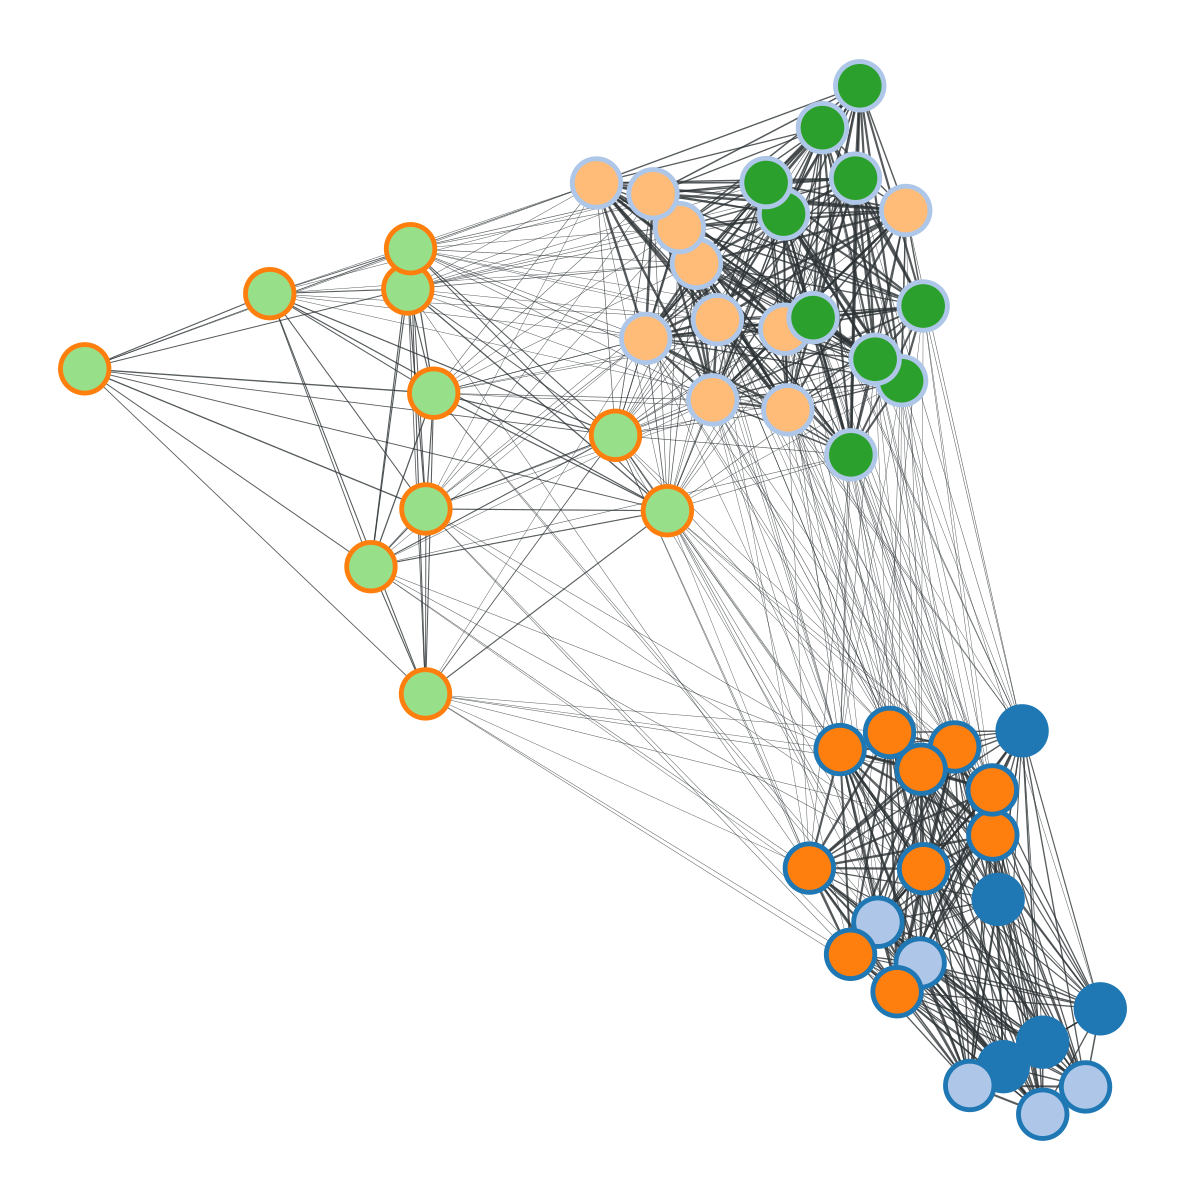

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x116b48ef0, at 0x1d1008170>

In [52]:
gene_expr = simulated_obs

g_non_mod = Graph(directed=False)
g_non_mod.add_vertex(n = 50)

spearman = g_non_mod.new_ep("double", 0)
pval = g_non_mod.new_ep("double", 0)

for i in range(50):
    for j in range(i):
        spearman_r = sp.stats.spearmanr(gene_expr[:,i], gene_expr[:,j])
        g_non_mod.add_edge(i, j)
        e = g_non_mod.edge(i, j)
        pval[e] = spearman_r[1]
        spearman[e] = spearman_r[0]

g_non_mod.edge_properties["pvalue"] = pval
g_non_mod.edge_properties["spearman"] = spearman
g_non_mod.ep.weight = g_non_mod.new_edge_property("double", 2*np.arctanh(spearman.a))

community = [0] * 5 + [1] * 5 + [2] * 10 + [3] * 10 + [4] * 10 + [5] * 10
g_non_mod.vp.community = g_non_mod.new_vertex_property("int", community)
upper = [6] * 20 + [7] * 20 + [8] * 10
g_non_mod.vp.upper = g_non_mod.new_vertex_property("int", upper)

tv = filterByFDR(g_non_mod, 1e-3, False)
g_non_mod_trim = Graph(tv, prune = False)
pos = arf_layout(g_non_mod_trim)
graph_draw(g_non_mod_trim, pos = pos, edge_pen_width = g_non_mod_trim.ep.weight, vertex_color=g_non_mod_trim.vp.upper , vertex_fill_color=g_non_mod_trim.vp.community)

In [53]:
state_non_mod = minimize_nested_blockmodel_dl(g_non_mod_trim, state_args=dict(recs=[g_non_mod_trim.ep.weight],
                                                              rec_types=["real-normal"], deg_corr=True))
mcmc_equilibrate(state_non_mod, wait=100, nbreaks=2, mcmc_args=dict(niter=10))

(226.11821592321013, 1001187, 324815)

In [54]:
# collect nested partitions
bs = []

def collect_partitions(s):
   global bs
   bs.append(s.get_bs())

# Now we collect the marginals for exactly 100,000 sweeps
mcmc_equilibrate(state_non_mod, force_niter=1000, mcmc_args=dict(niter=10),
                    callback=collect_partitions)

# Disambiguate partitions and obtain marginals
pmode = PartitionModeState(bs, nested=True, converge=True)
pv = pmode.get_marginal(g_non_mod_trim)

# Get consensus estimate
bs = pmode.get_max_nested()
state_non_mod = state_non_mod.copy(bs=bs[0:3])

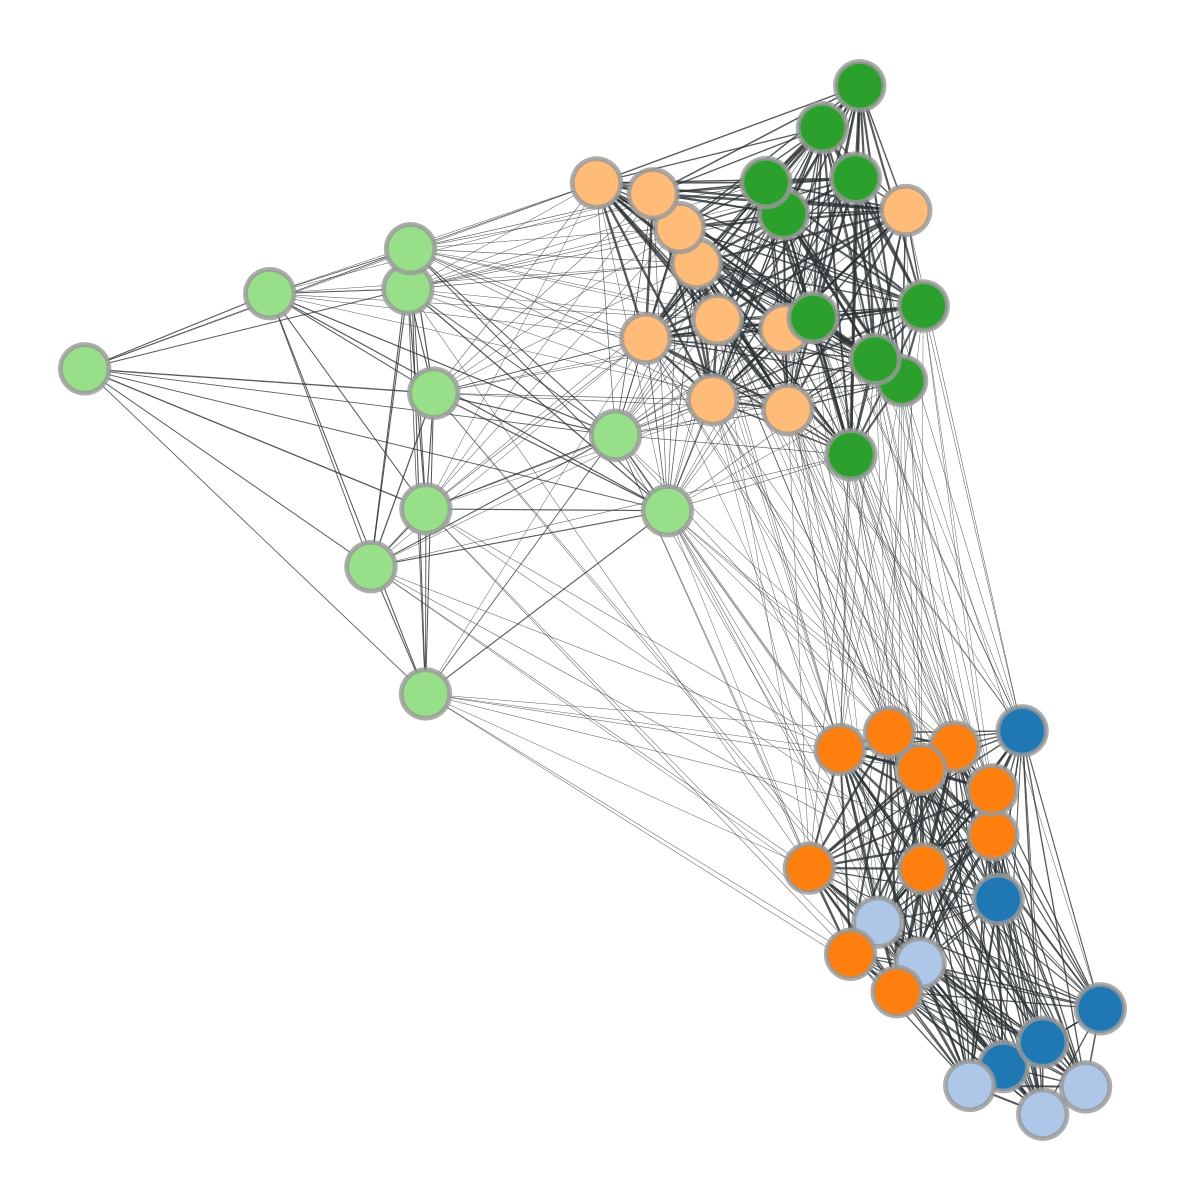

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x116b48ef0, at 0x1d1474410>

In [55]:
g_non_mod_trim.vp.level0 = g_non_mod_trim.new_vertex_property("int", np.array(state_non_mod.get_bs()[0]))
graph_draw(g_non_mod_trim, pos = pos, edge_pen_width = g_non_mod_trim.ep.weight, 
                                  vertex_fill_color = g_non_mod_trim.vp.level0)

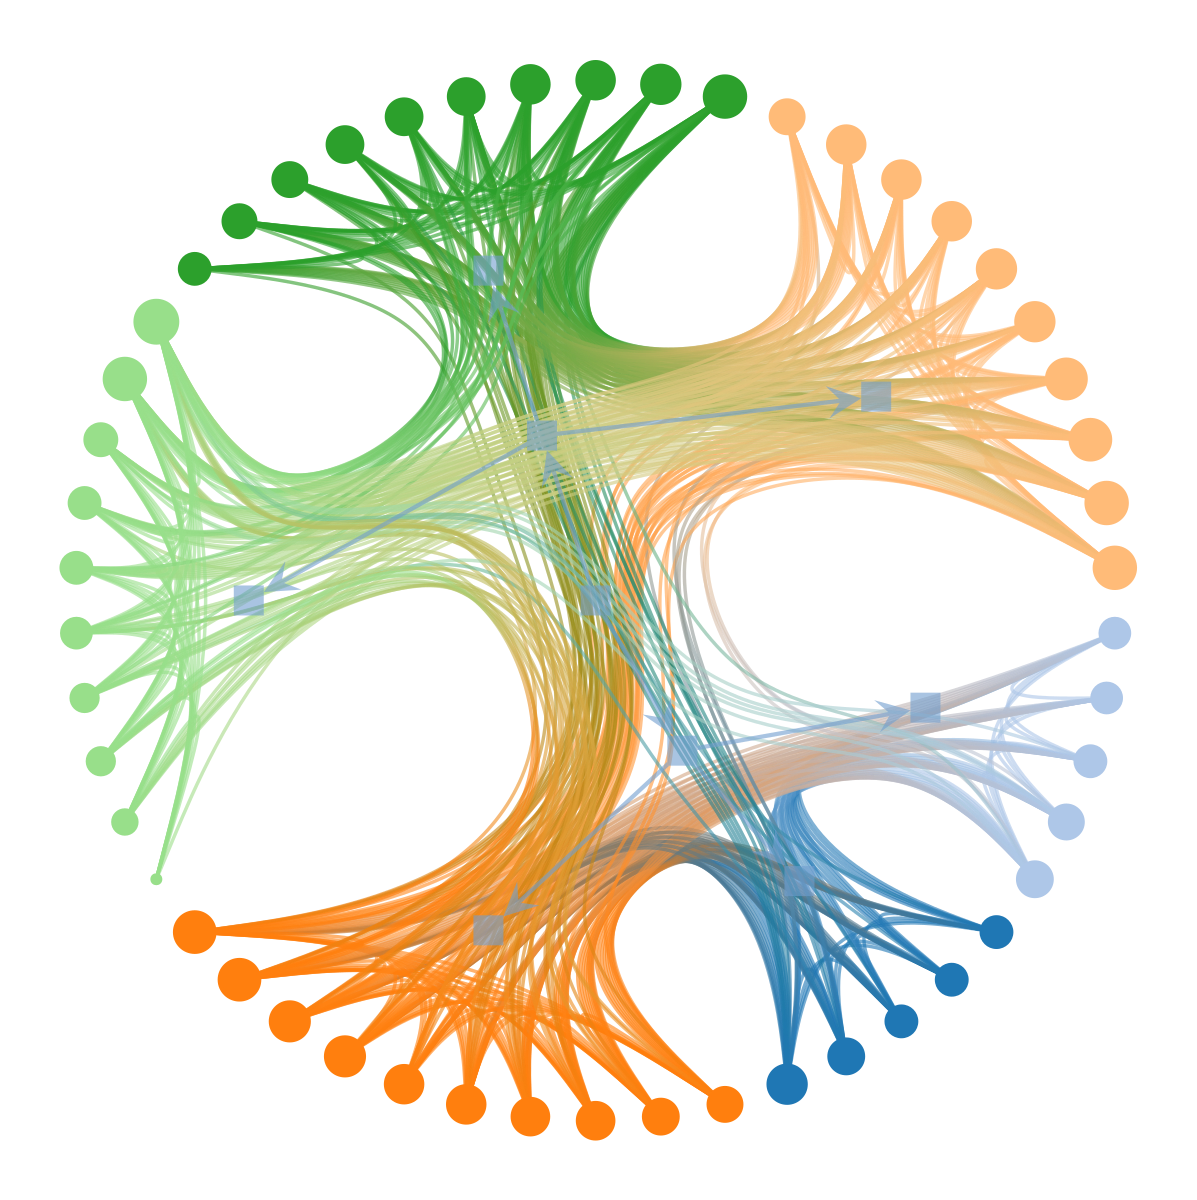

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x116b48ef0, at 0x1d100c7d0>,
 <GraphView object, directed, with 59 vertices and 58 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x1d10162d0, at 0x1d1015370>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x1d10162d0, at 0x1d1016870>, False), at 0x1d10162d0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x1d10162d0, at 0x1d0242810>)

In [56]:
state_non_mod.draw()